# Итоговый проект по бонустреку
# Тема работы: построение модели ИИ для решения задачи бинарной классификации 

Модель ИИ предсказывает класс для (мультипликационного) изображения: 
- 0 - обычный мультфильм (не аниме)
- 1 - аниме

Датасет был найден на платформе kaggle. Данный ноутбук запускался на платформе Kaggle. В input ноутбука на Kaggle был добавлен данный датасет.

Ссылка на датасет: https://www.kaggle.com/datasets/kanakmittal/anime-and-cartoon-image-classification/data

# Описание набора данных: 
Датасет содержит 2 директории: Anime и Cartoon. В директориях находятся поддиректории с названиями мультипликационных картин. В каждой поддиректории содержатся изображения из соответствующих картин.

## Импорт необходимых библиотек

In [1]:
!pip install torchsummary

In [2]:
import torch
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader, random_split, TensorDataset
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time
from torchsummary import summary

## Пример изображений из датасета

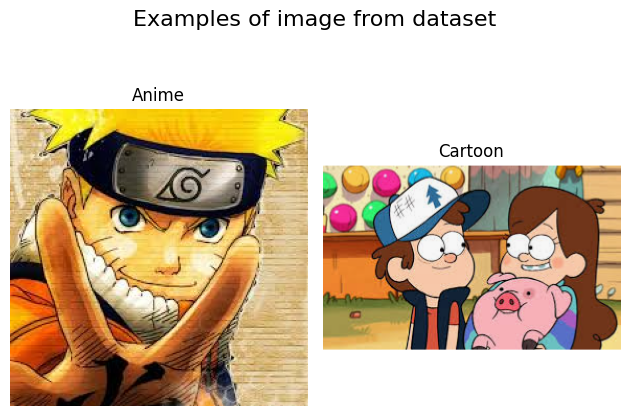

In [3]:
example_anime = Image.open('/kaggle/input/anime-and-cartoon-image-classification/Training Data/Anime/Naruto/121.jpg')
example_cartoon = Image.open('/kaggle/input/anime-and-cartoon-image-classification/Training Data/Cartoon/gravity falls/143.png')
fig, ax = plt.subplots(1,2)
ax[0].imshow(example_anime)
ax[1].imshow(example_cartoon)
ax[0].set_title('Anime')
ax[1].set_title('Cartoon')
fig.suptitle("Examples of image from dataset", fontsize=16)
plt.tight_layout()
plt.show()

# Предварительная обработка данных

Как видно из примера выше, картинки имеют разные размерности. Я собираюсь применять модель ResNet18, которая принимает на вход изображение размером 224x224. Чтобы избежать искажений масштаба при resize, применим предварительно обрезание картинки до квадратных размеров вокруг центра (class CenterCropToSquare), затем уже применим transforms.Resize((224, 224). 
Потом изображение надо перевести в формат torch Tensor для корректной работы нейросети. После этого идет нормализация. Здесь выбраны коэффициенты transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) в соответствии с датасетом ImageNet, так как модель ResNet18 была загружена с предобученными весами для датасета ImageNet. В данной работе производится Fine-tuning модели ResNet18

In [4]:
class CenterCropToSquare:
    def __call__(self, img):
        return self.crop_to_square(img)
    
    def crop_to_square(self, img):
        width, height = img.size
        min_side = min(width, height)
        left = (width - min_side) / 2
        top = (height - min_side) / 2
        right = (width + min_side) / 2
        bottom = (height + min_side) / 2
        return img.crop((left, top, right, bottom))

In [5]:
directory = Path('/kaggle/input/anime-and-cartoon-image-classification/Training Data')

image_paths = []
images = []
labels = []

transform = transforms.Compose([
    CenterCropToSquare(),
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

for anime_dir in (directory / 'Anime').iterdir():
    if anime_dir.is_dir():
        for image_file in anime_dir.glob('*'):
            image_paths.append(image_file.parent.name)
            image = Image.open(image_file).convert('RGB')
            image = transform(image)
            images.append(image)
            labels.append(1) # 1 - аниме

for cartoon_dir in (directory / 'Cartoon').iterdir():
    if cartoon_dir.is_dir():
        for image_file in cartoon_dir.glob('*'):
            image_paths.append(image_file.parent.name)
            image = Image.open(image_file).convert('RGB')
            image = transform(image)
            images.append(image)
            labels.append(0)  # 0 - мульт

images_tensor = torch.stack(images)
labels_tensor = torch.tensor(labels)

dataset = TensorDataset(images_tensor, labels_tensor)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Статистика по датасету

In [6]:
data = pd.DataFrame({'image_path': image_paths, 'label': labels})

In [7]:
def plot_stat(df, name_class):
    count = df['image_path'].value_counts()
    plt.figure(figsize=(10, 6))
    count.plot(kind='bar')
    plt.xticks(rotation=90, ha='right') 
    plt.title(f'{name_class} statistic')
    plt.xlabel(name_class+' name')
    plt.ylabel('count')
    plt.tight_layout() 
    plt.show()

In [8]:
cartoon_df = data.loc[data['label'] == 0] #мультфильм
anime_df = data.loc[data['label'] == 1] #аниме

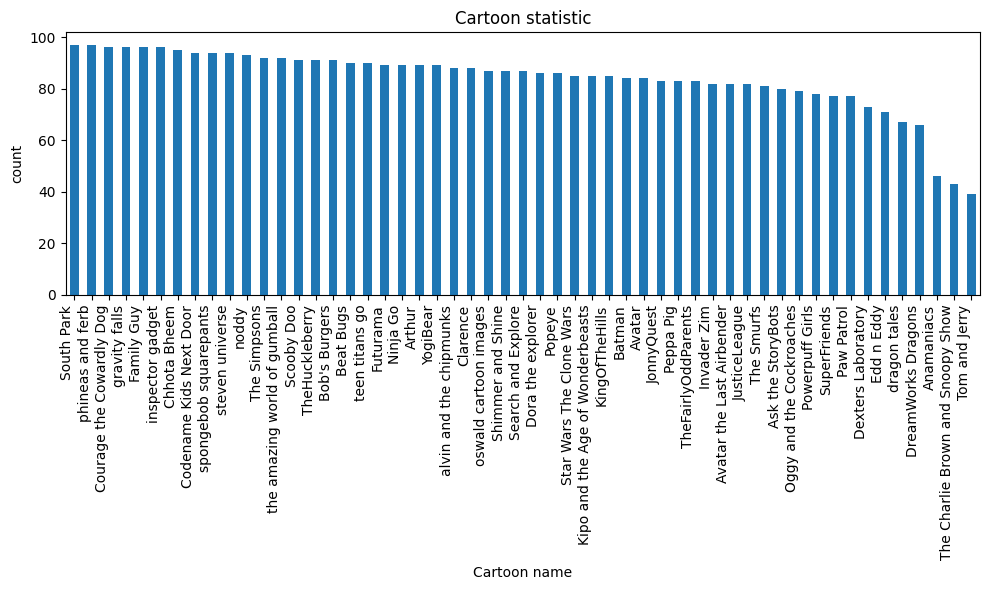

In [9]:
plot_stat(cartoon_df, 'Cartoon')

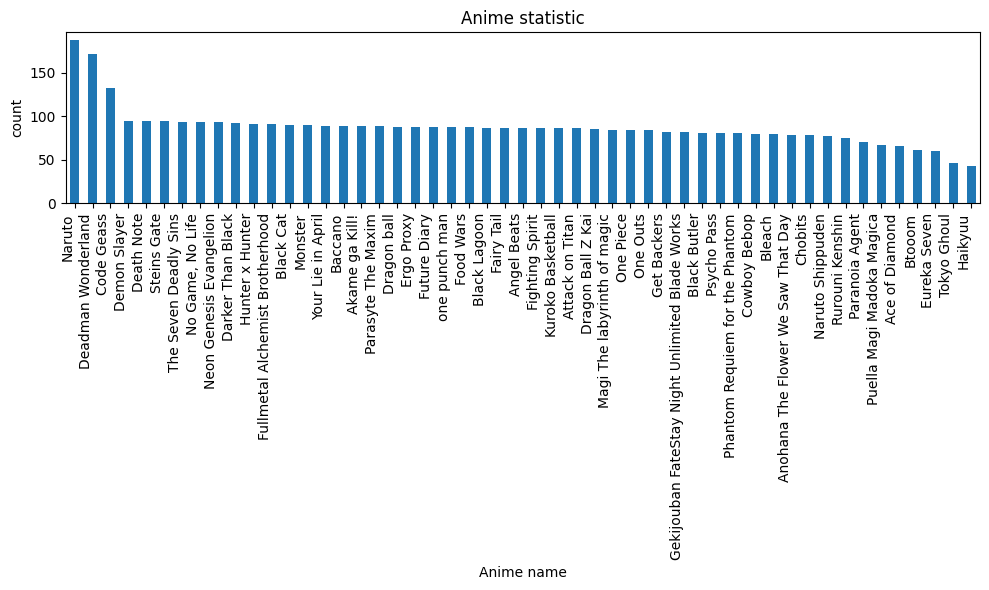

In [10]:
plot_stat(anime_df, 'Anime')

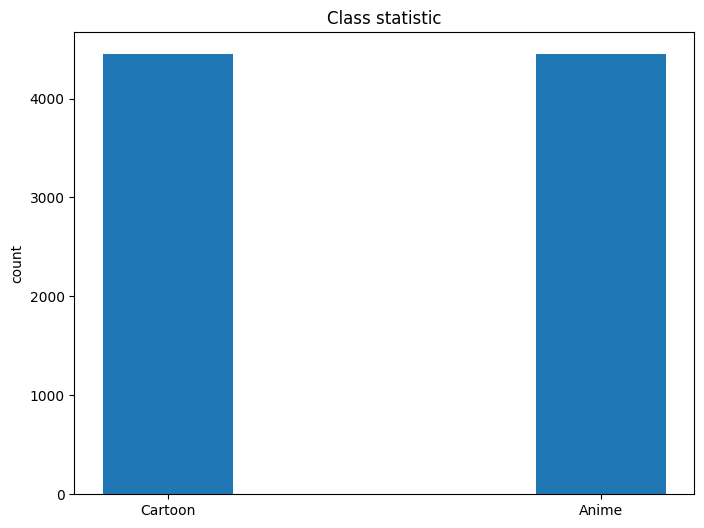

In [11]:
stat = {'Cartoon': len(cartoon_df), 'Anime': len(anime_df)}
plt.figure(figsize=(8, 6))
plt.bar(stat.keys(), stat.values(), width=0.3)
plt.title('Class statistic')
plt.ylabel('count')
plt.show()

# Постановка задачи и построение модели

Постановка задачи: fine-tuning модели Resnet18, предобученной на ImageNet, к текущему датасету.

Берется классическая архитектура Resnet18. Затем число выходных логитов изменяется на 2, так как обучаем бинарную классификацию.

Подбираем learning rate, чтобы график лосса был более гладким. 

In [12]:
def train(model, opt, loss_fn, epochs, history, device, train_dataloder, test_dataloder):
    start_time = time.time()
    for epoch in range(epochs):
        print('----- Epoch %d/%d -----' % (epoch+1, epochs))
        avg_loss_tr = 0
        model.train()
        for X_batch, Y_batch in train_dataloder:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            opt.zero_grad()
            Y_pred_0 = model(X_batch)
            loss = loss_fn(Y_pred_0, Y_batch)
            loss.backward()
            opt.step()
            avg_loss_tr += loss / len(train_dataloder)
        #gc.collect()
        history['train loss'].append(avg_loss_tr.detach().cpu().numpy())
        print('train loss: %f \n' % avg_loss_tr, end='  ')
        #torch.cuda.empty_cache()
        model.eval()
        with torch.no_grad():
            avg_loss_val = 0
            for X_batch, Y_batch in test_dataloder:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)
                Y_pred_0 = model(X_batch)
                loss_val = loss_fn(Y_pred_0, Y_batch)
                avg_loss_val += loss_val / len(test_dataloder)
        #gc.collect()
        history['val loss'].append(avg_loss_val.detach().cpu().numpy())
        print('val loss: %f \n' % avg_loss_val)
        weights_filename = f'weights_epoch{epoch+1}.pth'
        torch.save(model.state_dict(), weights_filename)
        print("--- %i seconds ---" % (time.time() - start_time))

In [13]:
epochs = 10
learning_rate = 1e-5
batch_size = 16
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # 2 логита: аниме и не аниме
#summary(model, (3, 224, 224))
print(model)

model = model.to(device)
loss_fn = nn.CrossEntropyLoss() # лосс кросс-энтропия
opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

history = {'train loss': [], 'val loss': []}
train(model, opt, loss_fn, epochs, history, device, train_dataloader, test_dataloader)

cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 149MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Оценка модели и результатов обучения

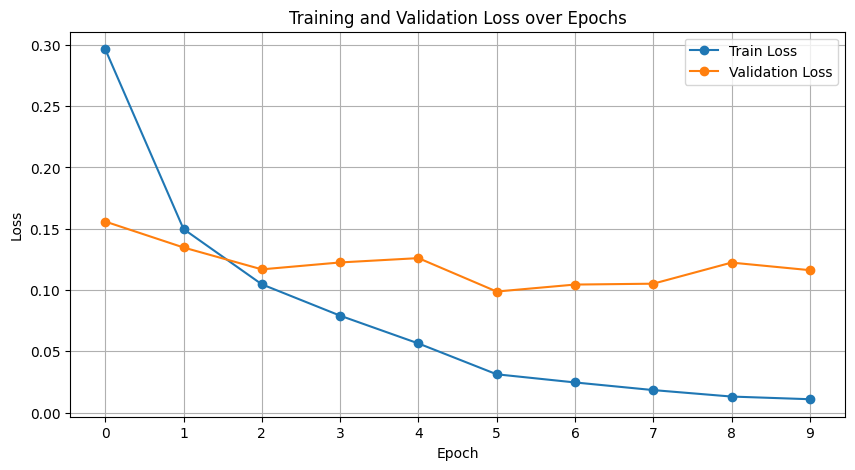

In [14]:
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history['train loss'], label='Train Loss', marker='o')
    plt.plot(history['val loss'], label='Validation Loss', marker='o')
    plt.xticks(range(len(history['train loss'])))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(history)

In [15]:
def predict_test_dataset(model, dataloader, device):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, true_labels

In [16]:
acc = []
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)
pred, lab = predict_test_dataset(model, test_dataloader, device)
acc.append(accuracy_score(lab, pred))
for i in range(1, epochs+1):
    model.load_state_dict(torch.load(f'/kaggle/working/weights_epoch{i}.pth'))
    model = model.to(device)
    pred, lab = predict_test_dataset(model, test_dataloader, device)
    acc.append(accuracy_score(lab, pred))

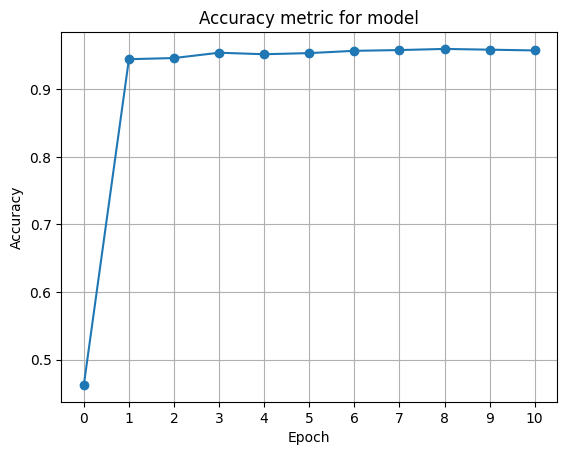

In [17]:
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(len(acc)))
plt.plot(acc, marker='o')
plt.title('Accuracy metric for model')
plt.grid(True)
plt.show()

После 5ой эпохи лосс на валидационной выборке перестает уменьшаться, а то время как лосс на тренировочной выборке продолжает уменьшаться - модель переобучается. Оптимальные эпохи для сохранения весов и последующего применения модели - 3, 4 или 5.

Метрика accuracy модели составляет около 95% (на 4ой эпохе)